<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [5]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import os
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from matplotlib import pyplot as plt
import datetime
import scipy.sparse as sps
from scipy.sparse import csr_matrix
from time import time

In [6]:
# подключение google colab, если не нужен, то закоментировать
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'drive/MyDrive/Colab_data/capstone_user_identification' 

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [8]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    #получить все файлы
    stock_files = sorted(glob(path_to_csv_files))
    
    #получить файл со словарем
    df_site_dict = pd.read_pickle(site_freq_path)
    
    #полуить первым шагом матрицу в соответствие с условиями
    data = []
    user = 1
    for filename in stock_files:
        tmp_df = pd.read_csv(filename)
        tmp_df['timestamp'] = pd.to_datetime(tmp_df['timestamp'])
        start_hour_site = list(tmp_df['timestamp'].dt.hour)
        day_of_week_site = list(tmp_df['timestamp'].dt.weekday)
        list_site = []
        list_time = list((tmp_df.iloc[:, 0].shift(-1)-tmp_df.iloc[:, 0])/np.timedelta64(1,'s'))
        list_time = list_time[0:len(list_time)-1]
        list_time = [round(x) for x in list_time]
        for site in tmp_df.site:                   
            list_site.append(df_site_dict.get(site))
        count = 0
        for start in range(0, (len(list_site) + window_size), window_size):
            ind_1 = start
            ind_2 = start + session_length
            sess_uniq = []
            if ind_2 <= (len(list_site)-1):
                sess = list_site[ind_1 : ind_2]
                sess_time = list_time[ind_1 : ind_2-1]
                sess_uniq = list(filter(lambda num: num != 0, sess))

                session = list([x for x,_ in list_site[ind_1:ind_2]])

                data.append(session + sess_time + [sum(sess_time)] + [len(set(sess_uniq))] + [start_hour_site[start]] + [day_of_week_site[start]] + [user])
            else:
                if(len(list_site[ind_1:])==0):
                    break
                sess = list_site[ind_1:] + [0 for _ in range(session_length - len(list_site[ind_1:]))]
                sess_uniq = list(filter(lambda num: num != 0, sess))
                sess_time = list_time[ind_1:] + [0 for _ in range(session_length - len(list_time[ind_1:])-1)]

                session = list([x for x,_ in list_site[ind_1:]]) + [0 for _ in range(session_length - len(list_site[ind_1:]))]

                data.append(session + sess_time + [sum(sess_time)] + [len(set(sess_uniq))] + [start_hour_site[start]] + [day_of_week_site[start]] + [user])

        user = user + 1

    df = pd.DataFrame(data, columns = feature_names)
    
    return df.drop_duplicates()

**Проверим функцию на игрушечном примере.**

In [9]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']

In [10]:
%%time

train_data_toy = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '3users/*'), 
                                               site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'),
                                               feature_names=feature_names, session_length=10)

CPU times: user 26.1 ms, sys: 0 ns, total: 26.1 ms
Wall time: 29.7 ms


In [11]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,10,8,8,4,8,5,1,6,2,9,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,10,5,5,5,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,10,8,3,3,8,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,7,5,8,5,8,5,5,6,11,7,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,7,5,8,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [12]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users/*'), 
                                               site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                               feature_names=feature_names, session_length=10)

CPU times: user 585 ms, sys: 44.2 ms, total: 629 ms
Wall time: 649 ms


In [13]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1314,2306,4318,4172,4318,4318,4172,4318,2455,4318,10,0,0,1,20,1,0,1,0,33,5,8,4,1
1,4869,3050,2897,941,4318,206,252,1663,2354,3722,1,0,163,105,0,1,3,3,8,284,10,8,4,1
2,3722,4172,3722,3722,4104,3069,4869,2906,993,3722,0,14,1,242,0,0,1,0,0,258,7,8,4,1
3,370,1837,370,3722,3722,3722,3722,3589,3056,348,2,1,0,1,25,1,0,0,0,30,6,8,4,1
4,2993,3722,4104,1659,2336,2915,1759,629,1063,629,1,0,1,1,1,0,1,1,0,6,9,8,4,1


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [14]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users/*'), 
                                               site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                               feature_names=feature_names, session_length=10)

CPU times: user 5.66 s, sys: 222 ms, total: 5.88 s
Wall time: 6.14 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [15]:
new_feature_names = ['time_diff' + str(j) for j in range(1,10)] + \
                    ['session_timespan', '#unique_sites', 'start_hour','day_of_week']

In [16]:
new_features_10users = train_data_10users[new_feature_names]
new_features_150users = train_data_150users[new_feature_names]

In [17]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [18]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
#train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [19]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

In [20]:
x = train_data_10users[train_data_10users.session_timespan < 200].session_timespan

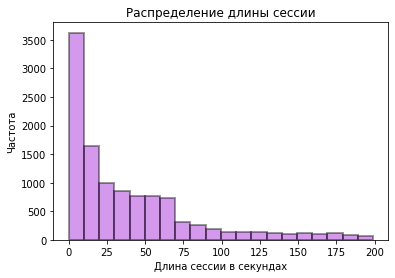

In [21]:
fig, ax = plt.subplots()
sns.distplot(x, bins=20, kde=False, color='darkviolet', hist_kws=dict(edgecolor="k", linewidth=2))
plt.title("Распределение длины сессии")
plt.xlabel("Длина сессии в секундах")
plt.ylabel("Частота")
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

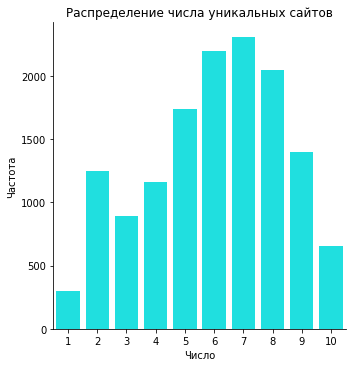

In [22]:
ax = sns.catplot(x="#unique_sites", kind="count", color='aqua', data=train_data_10users)
plt.title("Распределение числа уникальных сайтов")
plt.xlabel("Число")
plt.ylabel("Частота")
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

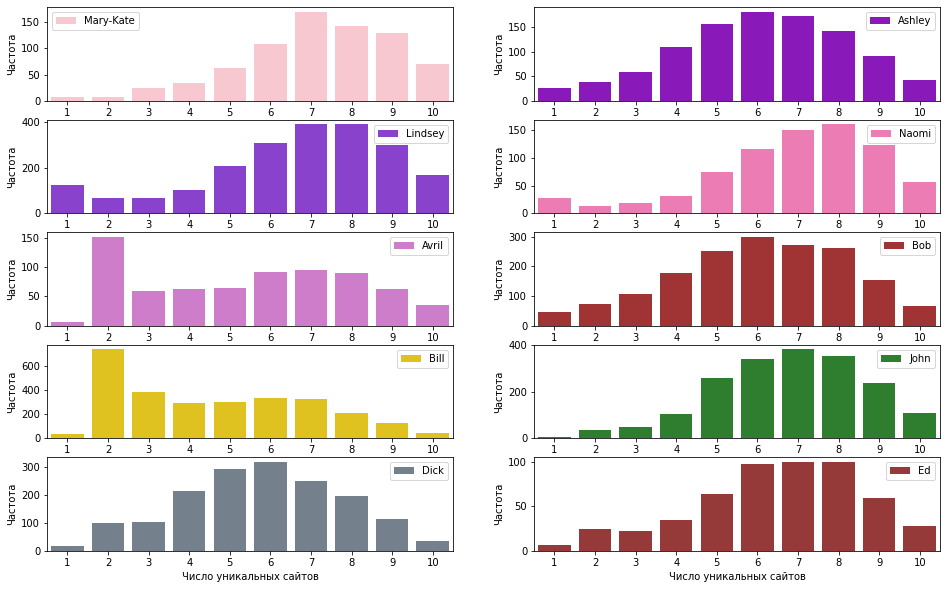

In [23]:
list_user = list(color_dic.keys())

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 10))
set_user = set(train_data_10users.target)

user = 1
for idx, ax in enumerate(axes):
    for i, a in enumerate(ax):
        sns.countplot(train_data_10users[train_data_10users.target == user]["#unique_sites"], color=color_dic[list_user[user-1]], ax=axes[idx, i])
        axes[idx, i].set_xlabel('Число уникальных сайтов')
        axes[idx, i].set_ylabel('Частота')
        axes[idx, i].legend([list_user[user-1]])
        user = user + 1

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

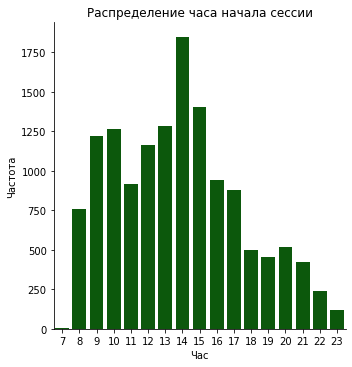

In [24]:
ax = sns.catplot(x="start_hour", kind="count", color='darkgreen', data=train_data_10users)
plt.title("Распределение часа начала сессии")
plt.xlabel("Час")
plt.ylabel("Частота")
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

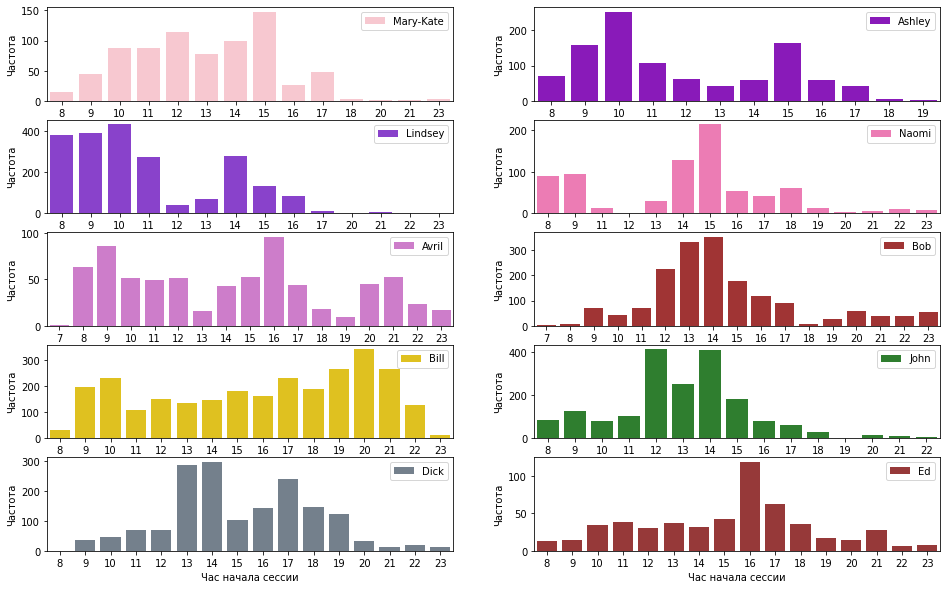

In [25]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 10))
set_user = set(train_data_10users.target)

user = 1
for idx, ax in enumerate(axes):
    for i, a in enumerate(ax):
        sns.countplot(train_data_10users[train_data_10users.target == user]["start_hour"],
                      color=color_dic[list_user[user-1]], 
                      ax=axes[idx, i])
        axes[idx, i].set_xlabel('Час начала сессии')
        axes[idx, i].set_ylabel('Частота')
        axes[idx, i].legend([list_user[user-1]])
        user = user + 1

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

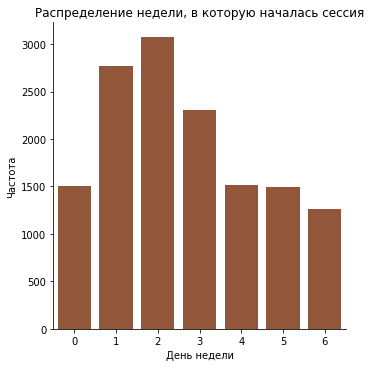

In [26]:
ax = sns.catplot(x="day_of_week", kind="count", color='sienna', data=train_data_10users)
plt.title("Распределение недели, в которую началась сессия")
plt.xlabel("День недели")
plt.ylabel("Частота")
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

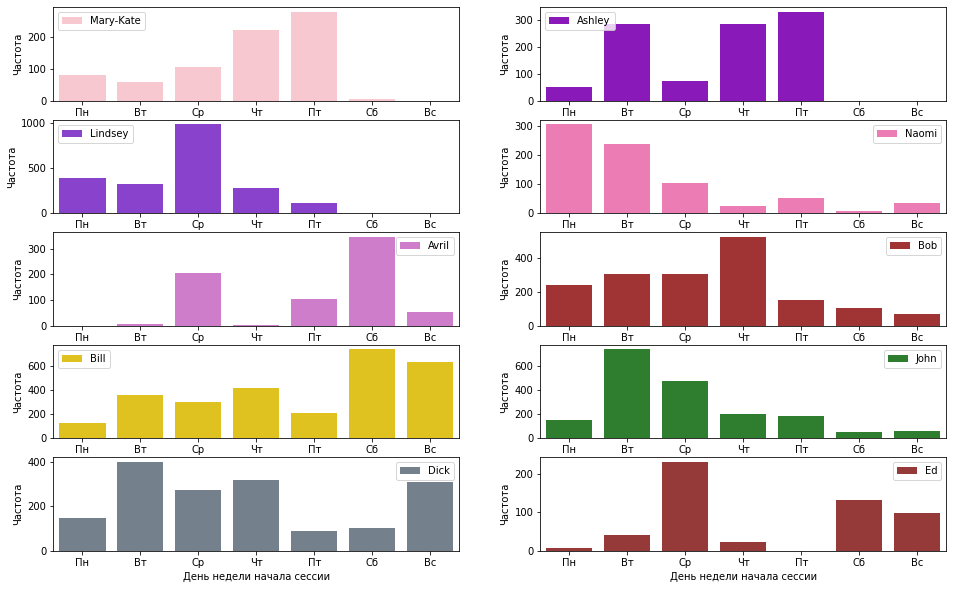

In [27]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 10))

user = 1
for idx, ax in enumerate(axes):
    for i, a in enumerate(ax):
        sns.countplot(train_data_10users[train_data_10users.target == user]["day_of_week"],
                      color=color_dic[list_user[user-1]], order = [0, 1, 2, 3, 4, 5, 6], ax=axes[idx, i])
        axes[idx, i].set_xlabel('День недели начала сессии')
        axes[idx, i].set_ylabel('Частота')
        axes[idx, i].legend([list_user[user-1]])
        axes[idx, i].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб',  'Вс'])
        user = user+1

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

* 'Mary-Kate' — частота количества уникальных сайтов совпадает с общей максимальной частотой (7). Время начала сессии на час больше, чем общее. День начала сессии отличается чт и пт, а в общих случаях это вт и ср.

* 'Ashley' — частота количества уникальных сайтов на один сайт меньше (6) в сравнении общей максимальной частотой (7). Время начала сессии в основном в 10, а в общих случаях пользователи начинают в 14. День начала сессии отличается вт, чт и пт, а в общих случаях это вт и ср.

* 'Lindsey' — частота количества уникальных сайтов совпадает с общей максимальной частотой (7). Время начала сессии в основном в 10, а в общих случаях пользователи начинают в 14. День начала сессии отличается ср, а в общих случаях это вт и ср.

* 'Naomi' — частота количества уникальных сайтов больше на один сайт (8) в сравнении с общей максимальной частотой (7). Время начала сессии в основном в 15, а в общих случаях пользователи начинают в 14. День начала сессии отличается пн, вт, а в общих случаях это вт и ср.

* 'Avril' — частота количества уникальных сайтов (2) меньше в сравнении с общей максимальной частотой (7). Время начала сессии в основном в 16, а в общих случаях пользователи начинают в 14. День начала сессии отличается сб, а в общих случаях это вт и ср.

* 'Bob' — частота количества уникальных сайтов (6) меньше в сравнении с общей максимальной частотой (7). Время начала сессии в основном в 14, что совпадает с общими случаями, пользователи начинают в 14. День начала сессии отличается чт, а в общих случаях это вт и ср.

* 'Bill' — частота количества уникальных сайтов (2) меньше в сравнении с общей максимальной частотой (7). Время начала сессии в основном в 20, что отличается с общими случаями, пользователи начинают в 14. День начала сессии отличается сб, вс, а в общих случаях это вт и ср.

* 'John' — частота количества уникальных сайтов (7) совпадает с общей максимальной частотой (7). Время начала сессии в основном в 12 и 14, что совпадает с общими случаями, пользователи начинают в 14. День начала сессии совпадают вт, ср и в общих случаях это вт и ср.

* 'Dick' — частота количества уникальных сайтов (6) отличается с общей максимальной частотой (7). Время начала сессии в основном в 13 и 14, что совпадает с общими случаями, пользователи начинают в 14. День начала сессии совпадают вт, ср и в общих случаях это вт и ср.

* 'Ed' — частота количества уникальных сайтов (7) совпадает с общей максимальной частотой (7). Время начала сессии в основном в 16, что отличается с общими случаями, пользователи начинают в 14. День начала сессии отличается ср ,а в общих случаях это вт и ср.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [28]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as fid:
    site_freq_10 = pickle.load(fid)

In [29]:
def itemgetter_own(*items):
    if len(items) == 1:
        item = items[0]
        def g(obj):
            return obj[item][1]
    return g

top10_popular = sorted(site_freq_10.items(), key=itemgetter_own(1), reverse=True)[:10]

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [30]:
top10_freqs = [freq for _, (ind, freq) in top10_popular]
top10_sites = [site for site, _ in top10_popular]

for i in range (0,10):
    print(top10_sites[i], top10_freqs[i])

s.youtube.com 8300
www.google.fr 7813
www.google.com 5441
mail.google.com 4158
www.facebook.com 4141
apis.google.com 3758
r3---sn-gxo5uxg-jqbe.googlevideo.com 3244
r1---sn-gxo5uxg-jqbe.googlevideo.com 3094
plus.google.com 2630
accounts.google.com 2089


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

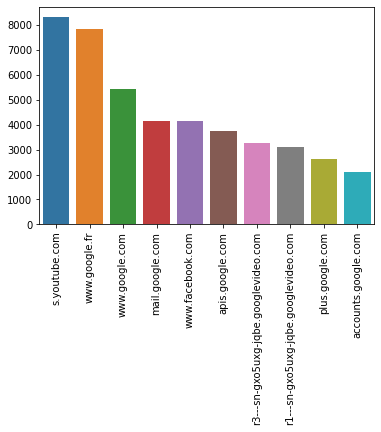

In [31]:
sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(rotation=90);

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [32]:
import statistics
statistics.median(train_data_10users.session_timespan.values)

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [33]:
statistics.median(train_data_10users.day_of_week.values)

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [34]:
statistics.median(train_data_150users.start_hour.values)

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [35]:
statistics.median(train_data_150users['#unique_sites'].values)

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [36]:
from itertools import combinations

def feature_engineering(df_data):
    df_new_data = df_data.copy()
    df_new_data['log_session_timespan'] = df_new_data['session_timespan'].apply(lambda x: np.log(x + 1))
    df_new_data['session_ts_avg'] = df_new_data['session_timespan']/df_new_data['#unique_sites']
    df_new_data['log_sess_ts_avg'] = df_new_data['log_session_timespan']/df_new_data['#unique_sites']
    df_new_data['ind_morning'] = df_new_data['start_hour'].apply(lambda x: int(6 <= x and x < 12))
    df_new_data['ind_afternoon'] = df_new_data['start_hour'].apply(lambda x: int(12 <= x and x < 18))
    df_new_data['ind_evening'] = df_new_data['start_hour'].apply(lambda x: int(18 <= x and x < 24))
    df_new_data['ind_night'] = df_new_data['start_hour'].apply(lambda x: int(0 <= x and x < 6))
    df_new_data['ind_weekend'] = df_new_data['day_of_week'].apply(lambda x: int(x >= 5))
    time_diff_list = ['time_diff' + str(i) for i in range(1,10)]
    df_new_data['low_time_diff'] = (df_new_data[time_diff_list].apply(np.abs) < 2).sum(axis = 1)
    new_features_list = ['log_session_timespan', 'session_ts_avg', 'log_sess_ts_avg', 'ind_morning',
                        'ind_afternoon', 'ind_evening', 'ind_night', 'ind_weekend', 'low_time_diff']
    for (i, j) in combinations(['site' + str(i) for i in range(1, 11)], 2):
        df_new_data[i + "#" + j] = df_new_data[i].apply(str) + "#" + df_new_data[j].apply(str)
        new_features_list.append(i + "#" + j)
    return df_new_data[new_features_list]

In [37]:
new_new_features_10users = feature_engineering(train_data_10users)

In [38]:
new_new_features_150users = feature_engineering(train_data_150users)

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [39]:
new_new_features_10users_plot = pd.concat([new_new_features_10users, train_data_10users['start_hour']], axis=1)

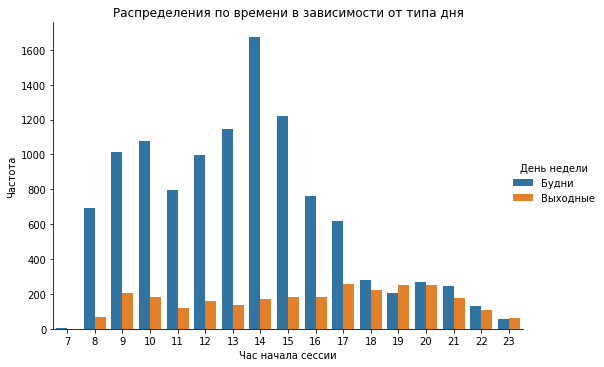

In [40]:
ax = sns.catplot(x="start_hour", kind="count", hue="ind_weekend", data=new_new_features_10users_plot, aspect=1.5)
ax._legend.set_title('День недели')
for t, l in zip(ax._legend.texts, ['Будни', 'Выходные']): t.set_text(l)

plt.title("Распределения по времени в зависимости от типа дня")
plt.xlabel("Час начала сессии")
plt.ylabel("Частота")
plt.show()

In [41]:
new_new_features_10users_plot = pd.concat([new_new_features_10users_plot, train_data_10users['target']], axis=1)

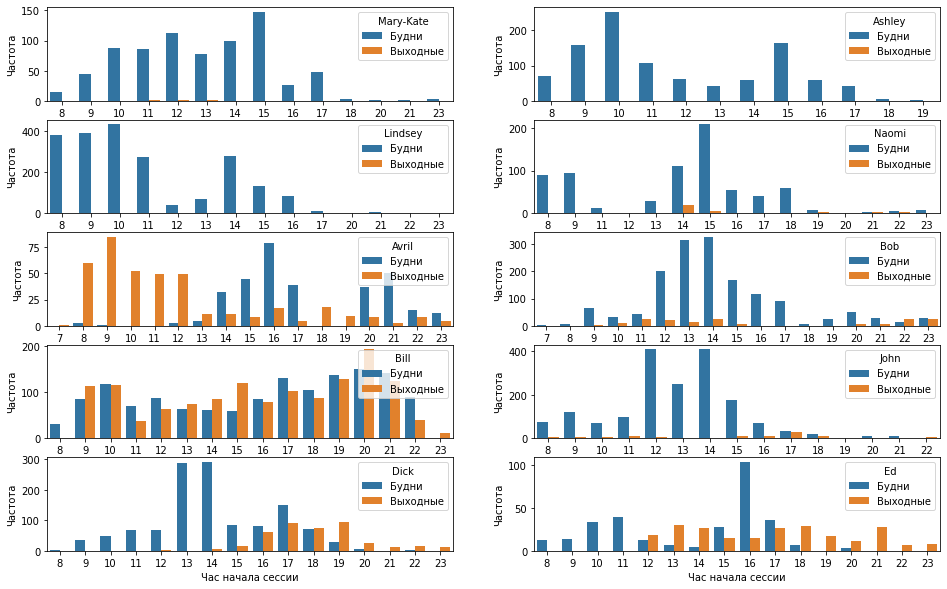

In [42]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 10))
user = 1
for idx, ax in enumerate(axes):
    for i, a in enumerate(ax):
        sns.countplot(new_new_features_10users_plot[(new_new_features_10users_plot.target == user)]["start_hour"], hue = 'ind_weekend',
                      data = new_new_features_10users_plot,
                      ax=axes[idx, i])
        axes[idx, i].set_xlabel('Час начала сессии')
        axes[idx, i].set_ylabel('Частота')
        axes[idx, i].legend(['Будни', 'Выходные'], title = list_user[user-1], loc = 'upper right')
        user = user + 1

Распределения по времени в зависимости от типа дня принес дополнительные характеристики по пользователям. Трое пользователей или вообще не открывают сайты, или очень мало открывают сайты, у четырех посещение сайтов в интернете в выходные значительно снижается, у троих оставшихся практически без изменений, только для двоих характерно смещение активности.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [43]:
selected_features_10users = pd.concat([new_features_10users, new_new_features_10users['ind_weekend']], axis=1)
selected_features_150users = pd.concat([new_features_150users, new_new_features_150users['ind_weekend']], axis=1)

In [44]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 